# 4D ResNet

In this notebook we'll train a "4D" ResNet model (strickly speaking: it's still a 3D ResNet) using "4D" images<br>
We will use 5-fold CV to make the outcome more reliable.

**4D images**
* each image has the following shape: Channel x Width x Height x Depth
* *channel:* the channel represents a specific MRI type. Further, <u>each</u> image contains all four MRI types (i.e., channel=4) --> That is why we say it is "4D"
* *depth:* the depth represents the depth or the number of slices. I tried various values >= 30. Caution: If for a given patient id, the number of images <= the number of slices, we will replace the missing depth slices with zero matrices.
* added some albumentation such as CLAHE, brightness, and CoarseDropout
* removed black pixels (see [Zabir Al Nazi Nabil](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train))

**4D ResNet18**
* copied and edited from [3D-ResNets-PyTorch](https://github.com/kenshohara/3D-ResNets-PyTorch)

**Slicing Strategy**
* take each x-th slice from each 3D image, whereby x (e.g., 2,4,6) depends on the maximum number of slices + take SLICING_NUMBER middle slices if SLICING_NUMBER < depth

#### Imports

In [1]:
import os
import random
import glob
import re

import pandas as pd

import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.optim import lr_scheduler

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2

import albumentations as A

from tqdm import tqdm

import wandb

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

#### Seed

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

#### Settings

In [3]:
PATH = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'

#### Config

In [4]:
config_dict = dict(
    # Pre-processing
    SLICE_NUMBER = 32, # >= 30
    REMOVE_BLACK_BOUNDARIES = True,
    DICOM=False,
    
    # Albumentation
    RRC_SIZE = 256,
    RRC_MIN_SCALE = 0.85,
    RRC_RATIO = (1., 1.),
    CLAHE_CLIP_LIMIT = 2.0,
    CLAHE_TILE_GRID_SIZE = (8, 8),
    CLAHE_PROB = 0.50,
    BRIGHTNESS_LIMIT = (-0.2,0.2),
    BRIGHTNESS_PROB = 0.40,
    HUE_SHIFT = (-15, 15),
    SAT_SHIFT = (-15, 15),
    VAL_SHIFT = (-15, 15),
    HUE_PROB = 0.64,
    COARSE_MAX_HOLES = 16,
    COARSE_PROB = 0.7,
    
    # K-Fold
    N_SPLITS = 5,
    
    # Training
    N_EPOCHS = 10,
    BATCH_SIZE = 32,
    LEARNING_RATE = 0.01,
    WEIGHT_DECAY = 0.02,
    OPTIMIZER = "SGD",
    MOMENTUM = 0.9,
    SCHEDULER = "ReduceLROnPlateau",
    
    # Logging
    VERBOSE = False,
    MODELNAME = "01-4D-ResNet-v4"
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### wandb

In [5]:
wandb.login()
run_name = f'{config_dict["MODELNAME"]}-{str(config_dict["SLICE_NUMBER"])}-{str(config_dict["RRC_SIZE"])}'
run = wandb.init(entity="uzk-wim", project='rsna-miccai-k-fold', config=config_dict, mode="online", group=run_name)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gusto (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### 1. Load Data

For each person, we were given *four* different MRI types: 
* FLAIR
* T1w
* T1wCE, and 
* T2w. 

We will create 4D images which are composed of each MRI type 3D image (4 sequences) where each sequence is composed of *config.SLICE_NUMBER* (e.g. 50) slices (i.e., depth).<br>
Shape:  *Channel x Width x Height x Depth*


### 1.1 Utilities

#### 1.1.1 Augmentation

In [6]:
train_transform = A.Compose([
    A.RandomResizedCrop(
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    ),
    A.CLAHE(
        clip_limit=config.CLAHE_CLIP_LIMIT,
        tile_grid_size=config.CLAHE_TILE_GRID_SIZE,
        p=config.CLAHE_PROB
    ),
    A.RandomBrightnessContrast(
        brightness_limit=config.BRIGHTNESS_LIMIT,
        p=config.BRIGHTNESS_PROB
    ),
    A.HueSaturationValue(
        hue_shift_limit=config.HUE_SHIFT, 
        sat_shift_limit=config.SAT_SHIFT, 
        val_shift_limit=config.VAL_SHIFT, 
        p=config.HUE_PROB
    ),
    A.CoarseDropout(
        max_holes=config.COARSE_MAX_HOLES,
        p=config.COARSE_PROB),
])

valid_transform = A.Compose([
    A.RandomResizedCrop( 
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    )
])

#### 1.1.2 Loading Images

In [7]:
def dicom_2_image(file, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(file)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        img = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        img = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        img = np.amax(img) - img
    
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    return img

def remove_black_boundaries(img):
    (x, y) = np.where(img > 0)
    if len(x) > 0 and len(y) > 0:
        x_mn = np.min(x)
        x_mx = np.max(x)
        y_mn = np.min(y)
        y_mx = np.max(y)
        if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
            img = img[:,np.min(y):np.max(y)]
    return img

def get_middle_idxs(mri_type):
    # Take SLICE_NUMBER slices from the middle
    threshold = config.SLICE_NUMBER // 2
    minimum_idx = len(mri_type)//2 - threshold if (len(mri_type)//2 - threshold) > 0 else 0
    maximum_idx = len(mri_type)//2 + threshold  # maximum can exceed the index
    step = 1
    if config.VERBOSE:
        print(f"Minimum {minimum_idx}")
        print(f"Maximum {maximum_idx}")
    return minimum_idx, maximum_idx, step

def get_xth_idxs(img_depth):
    minimum_idx = 0
    maximum_idx = img_depth
    step = 1
    if config.SLICE_NUMBER < img_depth:
        mod = img_depth % config.SLICE_NUMBER
        threshold = int(mod // 2)
        minimum_idx = threshold
        maximum_idx = img_depth - threshold
        step = img_depth // config.SLICE_NUMBER
    if config.VERBOSE:
        print(f"Minimum {minimum_idx}")
        print(f"Maximum {maximum_idx}")
        print(f"Step size: {step}")
    return minimum_idx, maximum_idx, step

def get_3d_image(mri_type, aug, dicom):
    # Calculate the indices of the 2D images which should be considered for the 3D image
    img_depth = len(mri_type)
    if img_depth <= config.SLICE_NUMBER:
        minimum_idx, maximum_idx, step = get_middle_idxs(mri_type)
    elif img_depth <= config.SLICE_NUMBER*2:
        minimum_idx, maximum_idx, step = get_middle_idxs(mri_type)
    else:
        minimum_idx, maximum_idx, step = get_xth_idxs(img_depth)
    
    # Create list which contains all the 2D images which form the 3D image
    mri_img = []
    counter = 0
    for i in range(minimum_idx, maximum_idx, step):
        if i >= len(mri_type):
            break
        file = mri_type[i]
        
        # Load 2D image
        if dicom:
            img = dicom_2_image(file)
        else:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            
        # Remove black boundaries
        if config.REMOVE_BLACK_BOUNDARIES:
            img = remove_black_boundaries(img)
            
        # Augmentation
        if aug:
            transformed = train_transform(image=img)
            img = transformed["image"]
        else:
            transformed = valid_transform(image=img)
            img = transformed["image"]
            
        counter += 1
        if counter == config.SLICE_NUMBER:
            break
            
        mri_img.append(np.array(img))
    mri_img = np.array(mri_img).T
    
    # If less than SLICE_NUMBER slices, add SLICE_NUMBER - mri_img.shape[-1] images with only zero values
    if mri_img.shape[-1] < config.SLICE_NUMBER:
        if config.VERBOSE:
            print(f"Current slices: {mri_img.shape[-1]}")
        n_zero = config.SLICE_NUMBER - mri_img.shape[-1]
        mri_img = np.concatenate((mri_img, np.zeros((config.RRC_SIZE, config.RRC_SIZE, n_zero))), axis = -1)
    if config.VERBOSE:
        print(f"Shape of mri_img: {mri_img.shape}")
    return mri_img
    

def load_images(scan_id, aug=True, split="train", dicom=False):
    # Ascending sort
    file_ext = "png"
    if dicom:
        file_ext = "dcm"
    flair = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/FLAIR/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
    t1w = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T1w/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
    t1wce = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T1wCE/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
    t2w = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T2w/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
    
    if config.VERBOSE:
        print(f"Scan id {scan_id}")
    flair_img = get_3d_image(flair, aug, dicom)
    t1w_img = get_3d_image(t1w, aug, dicom)
    t1wce_img = get_3d_image(t1wce, aug, dicom)
    t2w_img = get_3d_image(t2w, aug, dicom)
    
    # Return 4D image: ChannelsxWidthxHeightxDepth
    # mri_img = (mri_img - np.mean(mri_img, axis=(0,1)))/np.std(mri_img, axis=(0,1))
    return np.moveaxis(np.array((flair_img, t1w_img, t1wce_img, t2w_img)), 0, 0)

#### 1.1.3 Example

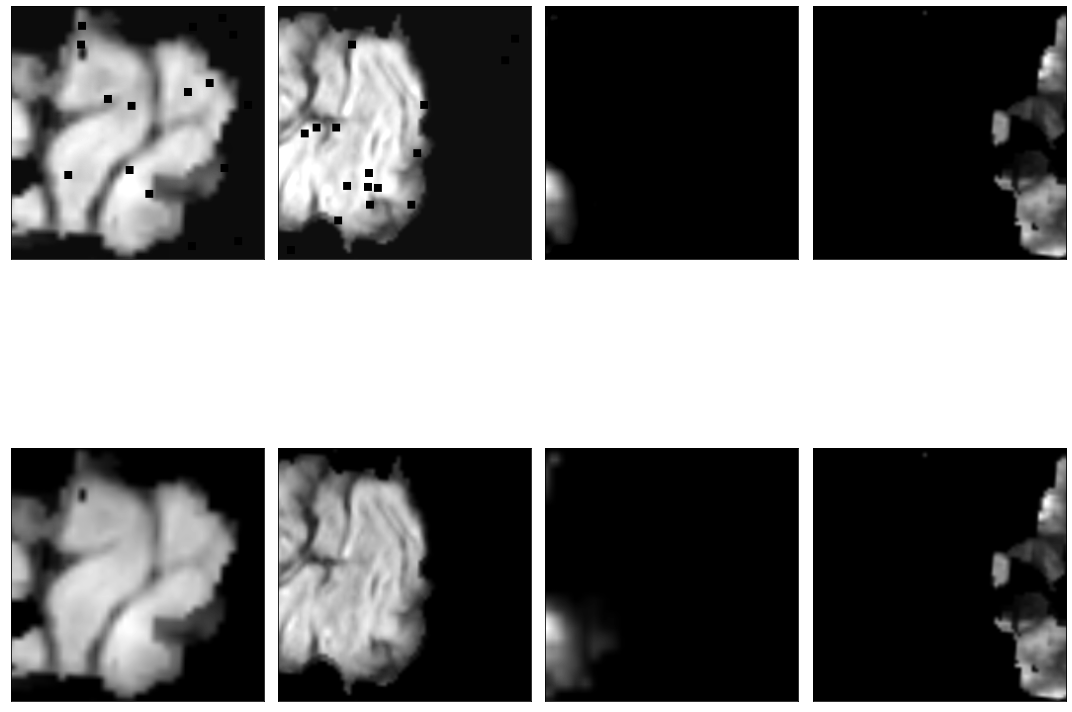

In [8]:
figure, axes = plt.subplots(2,4, figsize=(15,15))

slices_aug_1 = load_images("00002", aug=True)[0,:,:,0]
slices_no_aug_1 = load_images("00002", aug=False)[0,:,:,0]

slices_aug_2 = load_images("00011", aug=True)[0,:,:,0]
slices_no_aug_2 = load_images("00011", aug=False)[0,:,:,0]

slices_aug_3 = load_images("00028", aug=True)[0,:,:,0]
slices_no_aug_3 = load_images("00028", aug=False)[0,:,:,0]

slices_aug_4 = load_images("00054", aug=True)[0,:,:,0]
slices_no_aug_4 = load_images("00054", aug=False)[0,:,:,0]

im = axes[0,0].imshow(slices_aug_1, cmap="gray")
im = axes[0,1].imshow(slices_aug_2, cmap="gray")
im = axes[0,2].imshow(slices_aug_3, cmap="gray")
im = axes[0,3].imshow(slices_aug_4, cmap="gray")

for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
    
im = axes[1,0].imshow(slices_no_aug_1, cmap="gray")
im = axes[1,1].imshow(slices_no_aug_2, cmap="gray")
im = axes[1,2].imshow(slices_no_aug_3, cmap="gray")
im = axes[1,3].imshow(slices_no_aug_4, cmap="gray")

for ax in axes[1]:
    ax.set_xticks([])
    ax.set_yticks([])

figure.tight_layout()
plt.show()

### 1.2 Dataset and Dataloader

In [9]:
# Load ids and labels and make a stratified 80:20 split
df = pd.read_csv("../train_labels.csv")

In [10]:
class RSNADataset(Dataset):
    def __init__(self, ids, labels, split="train", dicom=False):
        self.ids = ids
        self.labels = labels
        self.split = split
        self.dicom = dicom
        
        remove_ids = [709, 109, 123]
        self.ids = [id_ for id_ in self.ids if id_ not in remove_ids]  
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        patient_id = self.ids[idx]
        patient_id = str(patient_id).zfill(5)
        if self.split == "train":
            imgs = load_images(patient_id, aug=True, dicom=self.dicom)
        elif self.split == "valid":
            imgs = load_images(patient_id, aug=False, dicom=self.dicom)
        else:
            imgs = load_images(patient_id, aug=False, split=self.split, dicom=self.dicom)
        # Normalize
        imgs = imgs - imgs.min()
        imgs = (imgs + 1e-5) / (imgs.max() - imgs.min() + 1e-5)

        if self.split != "test":
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(self.labels[idx], dtype = torch.long)
        else:
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(self.ids[idx], dtype = torch.float32)

### 1.3 Model

In [11]:
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, block_inplanes, n_input_channels=4, conv1_t_size=7, conv1_t_stride=1, no_max_pool=False,
                 shortcut_type='B', widen_factor=1.0, n_classes=2):
        super().__init__()
        
        # For wider ResNets only
        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]  # 64
        self.no_max_pool = no_max_pool

        # First Block: Convolutional Layer + Batch Normalization + ReLu + Max Pooling
        self.conv1 = nn.Conv3d(n_input_channels, self.in_planes, kernel_size=(conv1_t_size, 7, 7), stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        # Example ResNet18: Each layer consists of two residual blocks and two residual connections
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        # Initialization
        for m in self.modules():
            # He initialization
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample = nn.Sequential(conv1x1x1(self.in_planes, planes * block.expansion, stride), 
                                           nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [12]:
# ResNet18
model = ResNet(BasicBlock, [2, 2, 2, 2], [64, 128, 256, 512])
# ResNet34
#model = ResNet(BasicBlock, [3, 4, 6, 3], [64, 128, 256, 512])
# ResNet50
#model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])
# ResNet101
#model = ResNet(Bottleneck, [3, 4, 23, 3], [64, 128, 256, 512])

### 1.4 Training

In [13]:
def training(net, n_epochs, optimizer, loss_function, scheduler, train_dl, valid_dl, current_fold):
    wandb.watch(net, loss_function, log='gradients', log_freq=10)
    
    best_loss = np.inf
    best_roc = 0

    # Iterate over the dataset n_epochs times
    for epoch in range(n_epochs):
        net.train()  # net.train() will notify all your layers that you are in training mode

        train_loss = 0  # Training loss in epoch
        y_train_list = []
        y_hat_train_list = []
        roc_train = 0.0

        # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
        for xb, yb in tqdm(train_dl, desc="Training"):
            optimizer.zero_grad()  # zero_grad clears old gradients from the last step

            xb = xb.to(device)
            yb = yb.to(device)

            y_hat = net(xb)  # Forward pass
            loss = loss_function(y_hat, yb)  # Calculate Loss

            loss.backward()  # Calculate the gradients (using backpropagation)
            optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.

            train_loss += loss.item()
            y_train_list.extend(yb.tolist())
            y_hat = F.softmax(y_hat)
            y_hat_train_list.extend(y_hat[:,1].tolist())
            
            if config.SCHEDULER == "OneCycleLR":
                scheduler.step()
                
        y_hat_train_list = [1 if x > 0.5 else 0 for x in y_hat_train_list]
        roc_train = roc_auc_score(y_train_list, y_hat_train_list)
        
        train_loss = train_loss/len(train_dl)
                
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_roc": roc_train})

        valid_loss = 0  # Validation loss in epoch
        y_valid_list = []
        y_hat_valid_list = []
        roc_valid = 0.0

        net.eval()  # net.eval() will notify all your layers that you are in evaluation mode
        with torch.no_grad():
            # Perform a prediction on the validation set  
            for xb_valid, yb_valid in tqdm(valid_dl, desc="Validation"):
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)

                y_hat = net(xb_valid)  # Forward pass
                loss = loss_function(y_hat, yb_valid)  # Calculate Loss

                valid_loss += loss.item()
                y_valid_list.extend(yb_valid.tolist())
                y_hat = F.softmax(y_hat)
                y_hat_valid_list.extend(y_hat[:,1].tolist())

        y_hat_valid_list = [1 if x > 0.5 else 0 for x in y_hat_valid_list]
        roc_valid = roc_auc_score(y_valid_list, y_hat_valid_list)
        
        valid_loss = valid_loss/len(valid_dl)
        
        if config.SCHEDULER == "ReduceLROnPlateau":
            scheduler.step(valid_loss)

        wandb.log({"epoch": epoch, "valid_loss": valid_loss, "valid_roc": roc_valid})
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            best_roc = roc_valid
            wandb.run.summary["best_loss"] = best_loss
            wandb.run.summary["best_roc"] = roc_valid
            torch.save(net.state_dict(), f'../models/{config.MODELNAME}-fold-{current_fold}-loss-{round(valid_loss, 3)}.pt')
            
    return best_loss, best_roc

In [14]:
# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# Create optimizer
if config.OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE, momentum=config.MOMENTUM)
elif config.OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters(),lr = config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
else:
    optimizer = torch.optim.AdamW(model.parameters(),lr = config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    
model.to(device)

# Scheduler
#  The 1cycle policy by fasti: https://sgugger.github.io/the-1cycle-policy.html
if config.SCHEDULER == "OneCycleLR":
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.03, steps_per_epoch=steps_per_epoch, epochs=config.N_EPOCHS)
else:
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.25)

In [15]:
loss_avg = []
roc_avg = []

kfold = StratifiedKFold(n_splits=config.N_SPLITS, shuffle=True, random_state=42)
for i, (idx_train, idx_valid) in enumerate(kfold.split(df, df["MGMT_value"])):
    if i > 0:
        run = wandb.init(entity="uzk-wim", project='rsna-miccai-k-fold', config=config_dict, mode="online", group=run_name)
    wandb.run.name = f"{config.MODELNAME}-{str(config.SLICE_NUMBER)}-{str(config.RRC_SIZE)}-{str(i)}"
    df_train = df.iloc[idx_train].copy()
    df_valid = df.iloc[idx_valid].copy()
    
    train_ds = RSNADataset(df_train["BraTS21ID"].to_numpy(), df_train["MGMT_value"].to_numpy(), dicom=config.DICOM)
    train_dl = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
    valid_ds = RSNADataset(df_valid["BraTS21ID"].to_numpy(), df_valid["MGMT_value"].to_numpy(), split='valid', dicom=config.DICOM)
    valid_dl = DataLoader(valid_ds, batch_size=config.BATCH_SIZE, shuffle=False)

    best_loss, best_roc = training(model, config.N_EPOCHS, optimizer, loss_function, scheduler, train_dl, valid_dl, i)
    loss_avg.append(best_loss)
    roc_avg.append(best_roc)
    
    run.finish()

Validation: 100%|██████████| 4/4 [01:21<00:00, 20.43s/it]


epoch,9
train_loss,0.65001
train_roc,0.61904
_runtime,4891
_timestamp,1629813448
_step,19
valid_loss,0.69187
valid_roc,0.51016
best_loss,0.68168
best_roc,0.51703


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,▄██▅▄▂▁▁▁▁
train_roc,▁▂▁▁▁▃▆█▇▇
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,▁█▇▂▄▁▁▁▁▁
valid_roc,▆▁▁▃▁█▃▁▁▂


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation: 100%|██████████| 4/4 [01:21<00:00, 20.29s/it]


epoch,9
train_loss,0.63744
train_roc,0.62566
_runtime,4880
_timestamp,1629818333
_step,19
valid_loss,0.69799
valid_roc,0.52683
best_loss,0.68696
best_roc,0.5234


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▂▁
train_roc,▁▆▅███▇▇▇█
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,█▅▁▅▄▂▂▂▃▂
valid_roc,█▃▁▅▁▁▃▂▂▁


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation: 100%|██████████| 4/4 [01:21<00:00, 20.46s/it]


epoch,9
train_loss,0.68085
train_roc,0.55248
_runtime,4891
_timestamp,1629823228
_step,19
valid_loss,0.66458
valid_roc,0.5997
best_loss,0.66216
best_roc,0.5851


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,█▃▆▃▃▁▆▄▄▄
train_roc,▁█▆▆▅█▆▅▄▅
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,▁▄▅▅▆▇▇█▇▇
valid_roc,▁▃▃▃█▃▃▃█▅


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation: 100%|██████████| 4/4 [01:23<00:00, 20.98s/it]


epoch,9
train_loss,0.69724
train_roc,0.53066
_runtime,4845
_timestamp,1629828077
_step,19
valid_loss,0.68812
valid_roc,0.52796
best_loss,0.68542
best_roc,0.52722


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,▇█▂▇▅▃▇▅▁▅
train_roc,▁▇█▃▆▆▅▆▇▅
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,▅█▃▇▅▅▄▁▃█
valid_roc,▇██████▇▁█


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation: 100%|██████████| 4/4 [01:20<00:00, 20.15s/it]


epoch,9
train_loss,0.68004
train_roc,0.56521
_runtime,4856
_timestamp,1629832937
_step,19
valid_loss,0.70496
valid_roc,0.54728
best_loss,0.70451
best_roc,0.54655


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_loss,▁▂▄█▃▁▃▄▂█
train_roc,▄█▄▂▅▅▅▁▃▂
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,▄▄▃▆▁▃▂█▇▂
valid_roc,▆▅█▆█▆▁▃▇█


Done